## Introduction

In this assignment, three kinds of Linear Support Vector Classifiers will be trained to classify Shirts and Jerseys from the ImageNet database. The first will be trained on full images (i.e. flattened `64px x 64px` RGB images, with `64 * 64 * 128 = 12,288` dimensions each), the second will be trained on a PCA-reduced representation (with 561 dimensions), while the third is trained on an LDA-representation (with just 1 dimensions, as there are only 2 class labels). We first import all available images, resize and cohere to a format that sk-learn respects,

In [4]:
shirts = glob("../18/Shirts/*") # 0 
jerseys  = glob("../18/Jerseys/*") # 1 

In [5]:
WIDTH = 64
HEIGHT = WIDTH
LABELS = ['jerseys', 'shirts']

# Array to hold training images
imgs = []
# Get target labels for LDA
y = []

def preprocess_clothing(dir, label):

    global imgs, y

    for img_path in dir:
        img = image.load_img(img_path, target_size=(WIDTH, HEIGHT))
        x = image.img_to_array(img)
        # Augment (size, size) to (samples, sizes, sizes)
        x = np.expand_dims(x, axis=0)
        
        imgs.append(x)
        y.append(label)


preprocess_clothing(shirts, label = 1)
preprocess_clothing(jerseys, label = 0)

imgs = np.vstack(imgs)
y = np.vstack(y)

# Complete preprocessing by flattening imgs
imgs_flat = imgs.reshape(len(imgs), WIDTH*HEIGHT*3)

# Rescale to help with optimization
scale  = StandardScaler().fit(imgs_flat)

imgs_flat = scale.transform(imgs_flat)

# Split into train/validation set
X_train, X_test, y_train, y_test = train_test_split(imgs_flat, y, test_size = 0.2)

# 2802, 12288
assert X_train.shape[0] + X_test.shape[0] == len(shirts) + len(jerseys), "Mangled Sizing"

## Basic SVC
We have an input matrix X with size (2,802, 12,288) - a total of 2802 images. We can now initialize the 'basic SVC' model with the best parameters and fit the model to the input data: flattened pixel data of jerseys and shirts,

In [ ]:
# Fit SVM model with linear kernel, default hyperparameters
start = time()
svm_base = svm.LinearSVC()
svm_base.fit(X_train, y_train.ravel())
stop = time()

training_time = round(stop - start, 2)

Test Accuracy Score: 0.5490196078431373 
 Train Accuracy Score: 0.9580544399821508 
 Training Time: 54.54s


<Figure size 360x360 with 0 Axes>

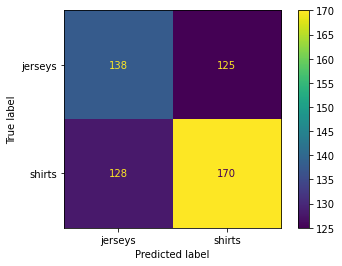

In [13]:
# Score basic linear kernel and show training time
print(
    "Test Accuracy Score:",  accuracy_score(y_test.ravel(), svm_base.predict(X_test)), '\n',
    "Train Accuracy Score:", accuracy_score(y_train.ravel(), svm_base.predict(X_train)), '\n',
    "Training Time:", f'{training_time}s'
)

# Show confusion matrix for test set
show_cm(y_test, svm_base, X_test)

After a training time of about 54 seconds, the basic SVC performs extremely well on the training set, with an overall accuracy of 95.8%. However, the strong contrast with the test set accuracy of 54.9% evinces a problem of overfitting. It seems that the classifier is learning "noise" in the images (creases, background elements - though these examples are lax abstractions over what actually happens) as discrenible traits of jerseys and shirts. This sense of overfitting is reinforced by the large number of support vectors relative to the total samples (1674 : 2802). From the confusion matrix plot, we also find that the model classifies jerseys modestly better than it does shirts (52.4% vs 57%). 

## PCA-Representation SVC

The process of dimensionality reduction is, in a sense, a process of feature summarization. To combat the problem of overfitting that assails the basic SVC above, we can train another SVC on data that is PCA-reduced. 

The quality of a PCA in describing the original data (ie total explained variance ratio) increases monotonically with the number of principal components, albeit at a decreasing rate. We want the explained variance ratio to be high, about 95%, which neatly corresponds to the number of samples in the test set,

(Note: this is not a rationale. The author just likes coincidences.)

In [14]:
# Transform to PCA representation, with as many components as possible
N_COMPONENTS = X_test.shape[0]

pca = PCA(n_components = N_COMPONENTS)
X_pca = pca.fit_transform(X_train)

# 12,288 -> 561 features
X_pca.shape, round(sum(pca.explained_variance_ratio_),2)

((2241, 561), 0.94)

An image's representation has been reduced from 12,288 dimensions to just 561. Our hope is that these new components capture the "essence" of jerseys and shirts. Before fitting, we scan for the best hyperparameters,

In [ ]:
params = {
    'C' : (1e-5, 1e-3, 1e-1, 1, 10),
    'tol': [1e-5, 1e-3],
    'max_iter': [10000]
}

clf_pca = GridSearchCV(svm.LinearSVC(), params, scoring = 'accuracy')
clf_pca.fit(X_pca, y_train.ravel())

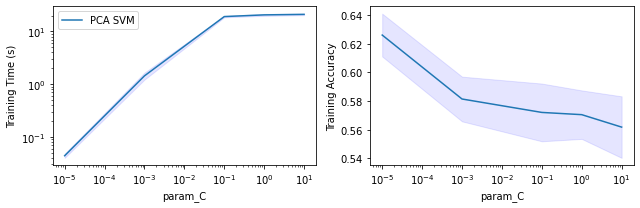

In [24]:
plot_paramsearch(clf_pca)

As we increase the C parameter, the model takes longer to train. Simultaneously, the training accuracy falls. We now fit the model with the best hyperparameters,

In [20]:
best_params  = clf_pca.best_estimator_.get_params()

svm_pca = svm.LinearSVC(
    **best_params)

start = time()
svm_pca.fit(X_pca, y_train.ravel())
stop = time()

pca_time = round(stop - start, 2)

Test Accuracy Score: 0.5971479500891266 
 Train Accuracy Score: 0.6880856760374833 
 Training Time: 0.07s


<Figure size 360x360 with 0 Axes>

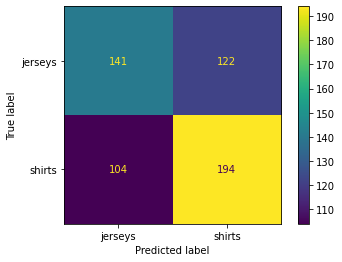

In [21]:
# Linear transform test data with principal components
X_test_pca = pca.transform(X_test)

# Score PCA-linear SVM and show training time
print(
    "Test Accuracy Score:",  accuracy_score(y_test.ravel(), svm_pca.predict(X_test_pca)), '\n',
    "Train Accuracy Score:", accuracy_score(y_train.ravel(), svm_pca.predict(X_pca)), '\n',
    "Training Time:", f'{pca_time}s'
)

# Show confusion matrix
show_cm(y_test, svm_pca, X_test_pca)

With substantially smaller training data, the PCA-model trains in just 0.07s. The closer alignment between test and training accuracy (59.7% and 68.8% respectively) indicates that the model is not as overfit and presumably learned good discriminants between jerseys and shirts. 

Specifically, it seems to classify Shirts (65.1%) better than Jerseys (53.6%) in the test set. These performance results on the test set outperform the basic SVC, both in terms of mean accuracy (59.7% vs 55.6%) and individual class predictions. 

## LDA-Representation SVC

The LDA is a *supervised* form of dimensionality reduction by incorporating class labels into the reduction process. By assuming a linear boundary to separate classes modeled by Gaussian densities, the technique is, in a sense, a classifier. At the same time, it can also be viewed as an extreme compressor, reducing the dimensionality to `1 - n_classes`, which here is just 1,

In [25]:
# Transform to LDA representation
lda = LinearDiscriminantAnalysis()
X_lda = lda.fit_transform(X_train, y_train.ravel())

X_lda.shape
# print(pd.DataFrame(np.hstack((X_lda[0:5], y_train[0:5]))).to_latex())

(2241, 1)

Sampling the first few LDA-representations of training images against their class labels,
we can see that positive representations correspond to 1, while negative representations correspond to 0,

$$
\begin{tabular}{lrr}
\toprule
{Sample} &   LDA-Representation &    Class Label \\
\midrule
0 &  4.405935 &  1.0 \\
1 &  4.405935 &  1.0 \\
2 & -4.847767 &  0.0 \\
3 & -4.847767 &  0.0 \\
4 &  4.405935 &  1.0 \\
\bottomrule
\end{tabular}
$$

We will now fit the final SVC using the LDA representation,

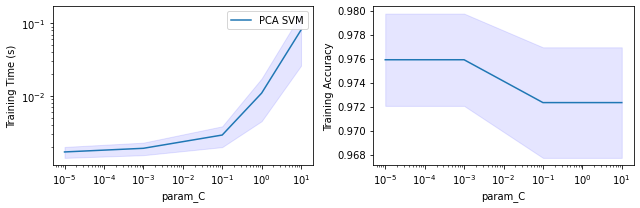

In [23]:
# Parameter Search for LDA
clf_lda = GridSearchCV(svm.LinearSVC(), params, scoring = 'accuracy')
clf_lda.fit(X_lda, y_train.ravel())

plot_paramsearch(clf_lda)

As we increase C, training time similarly increases. However, accuracy remains constant within bounds (the blue area is within 1 SD of the mean training time). We now fit the model and compute metrics,

In [78]:
# Use PCA rep to fit SVC
best_params  = clf_lda.best_estimator_.get_params()

start = time()
svm_lda  = svm.LinearSVC(**best_params)
svm_lda.fit(X_lda, y_train.ravel())
end = time()

lda_time = round(end - start, 3)

Test Accuracy Score: 0.5383244206773619 
 Train Accuracy Score: 0.9759036144578314 
 Training Time: 0.003s


<Figure size 360x360 with 0 Axes>

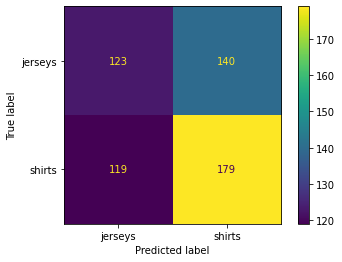

In [79]:
# Score LDA representation
X_test_lda = lda.transform(X_test)

print(
    "Test Accuracy Score:",  accuracy_score(y_test.ravel(), svm_lda.predict(X_test_lda)), '\n',
    "Train Accuracy Score:", accuracy_score(y_train.ravel(), svm_lda.predict(X_lda)), '\n',
    "Training Time:", f'{lda_time}s'
)

# Show confusion matrix
show_cm(y_test, svm_lda, X_test_lda)

The model trains substantially faster than the other two sets of SVCs (0.003s), but is as overfit as the basic SVC - training classification is very high at 97.5%, but test accuracy is 53.8%, the lowest of all SVCs we have covered. An LDA collapses image data to just one dimension, and in doing so overfits to the training data and fails to pick up salient features. 

As mentioned earlier, an LDA is equally a supervised classification technique with a linear decision boundary,

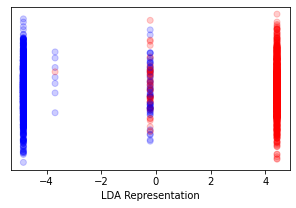

LDA Score: 0.98 
 SVC Score: 0.98


In [80]:
show_lda()

print(
    "LDA Score:", round(lda.score(X_train, y_train),2), '\n',
    "SVC Score:", round(
        accuracy_score(y_train.ravel(), 
        svm_lda.predict(X_lda)),2))

In the plot, points with red markers are from the Shirts class, while points with blue markers are from the Jerseys class. Visually, there is strong class separation at the margins, but not so much around 0 - this is the location where the majority of misclassifications occur.

A linear SVC trained on an LDA with a linear decision boundary will, as the plot and accompanying readout shows, simply redraw the same decision boundary. As such, our apparent gains in performance are due to the problem already being 'solved' by the LDA. In other words, the LDA-Representation SVC is just an LDA Classifier. 

## Recommendation

After analysing three variants of the linear SVC, the PCA-Representation SVC is the recommended model. As outlined clearly above, the model uses a less-noisy representation of images before training the model, reducing overfitting and increasing test accuracy overall. Additionally, the PCA model trains substantially faster than the basic model (0.07s vs 54s), which bodes well if we choose to increase the size of the training set. These performance gains are meaningful even when we consider the time to fit and transform the data using PCA (~2.6 seconds). The third model, while fast, is limited in its descriptive power and contains a redundant use of the SVC. 

# Technical Appendix

In [2]:
## Imports

from glob import glob
import numpy as np 

import pandas as pd

from time import time
import scipy.stats as sts


from tensorflow.keras.preprocessing import image
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn import svm


from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score

import matplotlib.pyplot as plt

In [69]:
## Plotting/ Misc Functions (run first)

def plot_paramsearch(clf):
    results = pd.DataFrame(clf.cv_results_)
    param_results = results.groupby('param_C').mean()

    fig = plt.figure(figsize=(9,3), tight_layout = True)

    plt.subplot(121)
    ax = param_results["mean_fit_time"].plot(label = "PCA SVM")

    ax.fill_between(
        param_results.index,
        param_results["mean_fit_time"] + param_results["std_fit_time"],
        param_results["mean_fit_time"] - param_results["std_fit_time"],
        alpha = 0.1,
        color = "blue"
    )

    ax.set_yscale('log')
    ax.set_xscale('log')

    ax.set_ylabel("Training Time (s)")

    #ax.semilogx(C, training_time, label = "Basic SVM")
    ax.legend()

    plt.subplot(122)

    ax2 = param_results['mean_test_score'].plot(label = "PCA SVM")
    ax2.fill_between(
        param_results.index,
        param_results["mean_test_score"] + param_results["std_test_score"],
        param_results["mean_test_score"] - param_results["std_test_score"],
        alpha = 0.1,
        color = "blue"
    )
    ax2.set_xscale('log')
    ax2.set_ylabel("Training Accuracy")

    plt.show()

def show_cm(y, model, x):
    plt.figure(figsize=(5,5))
    cm = confusion_matrix(y, model.predict(x))

    ConfusionMatrixDisplay(
        confusion_matrix = cm,
        display_labels=LABELS).plot()
    plt.show()

def show_lda():
    plt.figure(figsize=(5,3))
    ax = plt.gca()

    colors = ['red' if i == 1 else 'blue' for i in y_train.ravel()]

    ax.scatter(
        X_lda, 
        sts.norm.rvs(loc = 0, size = len(X_lda), 
        scale = 0.001),
        alpha = 0.2,
        color = colors)

    ax.set_yticks([])
    ax.set_xlabel("LDA Representation")

    plt.show()
